In [1]:
import pandas as pd
import psycopg2
import sqlalchemy
from sqlalchemy import create_engine

In [ ]:
conn = psycopg2.connect("host=localhost dbname=taxi_db_s user=postgres password='postgres'")
cur = conn.cursor()
#taxi_db = create_engine("sqlite:///taxi_db_l.db")

In [14]:
%%time
data_f =  pd.read_csv("taxi-sample.csv")
data_f = data_f.rename(columns={c: c.replace(' ', '') for c in data_f.columns})
#removing duplicates
data_f.drop_duplicates(keep='first', inplace=True)
#VendorID=4 
data_f = data_f.drop(data_f[data_f.VendorID==4].index)

# removing RateCodeID =99  
data_f = data_f.drop(data_f[data_f.RatecodeID==99].index)

#removing PULocationID =264, 265
data_f = data_f.drop(data_f[(data_f.PULocationID==264) | (data_f.PULocationID==265)].index)

#removing DOLocationID =264, 265
data_f = data_f.drop(data_f[(data_f.DOLocationID==264) | (data_f.DOLocationID==265)].index)

#removing -ve values of fare amount
data_f = data_f.drop(data_f[data_f.fare_amount<0].index)

#removing  mta_tax unknown values (other than 0,0.5)  
data_f = data_f.drop(data_f[~((data_f.mta_tax==0) | (data_f.mta_tax==0.5))].index)

#removing Extra(other than 0,0.5,1)
data_f = data_f.drop(data_f[~((data_f.extra==0) | (data_f.extra==0.5) | (data_f.extra==1))].index)

#removing Future Trips
#year + time from tpep_pickup  as a series 
col = data_f['tpep_pickup_datetime'].str.split('/')

for items in col.iteritems():
    #index
    ind = items[0]
    #year  
    yr_int= int(items[1][2].split(' ')[0])
    if yr_int > 2019:
        data_f=data_f.drop(ind)
    if yr_int == 2019:
        #month
        month_int = int(items[1][0])
        if month_int > 9:
            data_f = data_f.drop(ind)

data_f.count()

Wall time: 20 s


VendorID                 1008970
tpep_pickup_datetime     1008970
tpep_dropoff_datetime    1008970
passenger_count          1008970
trip_distance            1008970
RatecodeID               1008970
store_and_fwd_flag       1008970
PULocationID             1008970
DOLocationID             1008970
payment_type             1008970
fare_amount              1008970
extra                    1008970
mta_tax                  1008970
tip_amount               1008970
tolls_amount             1008970
improvement_surcharge    1008970
total_amount             1008970
dtype: int64

In [15]:
data_f.to_csv (r'taxi-sample-normalised.csv', index = None, header=True)

In [22]:
data_f.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
52,2,09/09/2019 11:33:53 AM,09/09/2019 03:10:50 PM,1,1.10,1,N,162,141,1,8.0,0.0,0.5,1.20,0.0,0.3,10.00
54,2,09/09/2019 11:07:13 AM,09/09/2019 11:26:59 AM,1,2.30,1,N,43,170,2,13.5,0.0,0.5,0.00,0.0,0.3,14.30
56,2,09/09/2019 10:42:03 AM,09/09/2019 10:53:56 AM,1,1.96,1,N,237,236,1,9.5,0.0,0.5,2.06,0.0,0.3,12.36
58,2,09/09/2019 10:19:44 AM,09/09/2019 10:31:26 AM,1,0.93,1,N,162,170,1,8.5,0.0,0.5,1.00,0.0,0.3,10.30
60,2,09/09/2019 09:44:31 AM,09/09/2019 09:50:15 AM,1,0.94,1,N,211,113,2,5.5,0.0,0.5,0.00,0.0,0.3,6.30


In [23]:
#create table commands
cur.execute('CREATE TABLE taxisample("VendorID" integer,tpep_pickup_datetime timestamp,tpep_dropoff_datetime timestamp, passenger_count integer,trip_distance real,"RatecodeID" integer,store_and_fwd_flag varchar,PULocationID integer,DOLocationID integer,payment_type integer,fare_amount real,extra real,mta_tax real,tip_amount real,tolls_amount real,improvement_surcharge real,total_amount real)')
conn.commit()

In [24]:
%%time
#copy csv to postgresql
with open("taxi-sample-normalised.csv", 'r') as f:
    next(f) # Skip the header row.
    cur.copy_from(f, 'taxisample', sep=',')
    conn.commit()

Wall time: 16.8 s


In [7]:
import geopandas as gp
import pandas as pd
import sqlite3 
import matplotlib.pyplot as plt

In [8]:
df = gp.read_file("taxi_zones.shp")
df.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((933100.9183527103 192536.0856972019,..."
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"(POLYGON ((1033269.243591294 172126.0078125, 1..."
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((1026308.769506663 256767.6975403726,..."
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.4667968601 203714.0759887695,..."
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((935843.3104932606 144283.335850656, ..."


In [9]:
%%time
import psycopg2
from sqlalchemy import create_engine

conn = psycopg2.connect("host=localhost dbname=movie-data user=postgres password='postgres'")
cur = conn.cursor()
# poor connectivity in 2018
cur.execute("select distinct DOLocationID,Store_and_fwd_flag from taxisample where date_part('year', tpep_pickup_datetime)=2018 and store_and_fwd_flag='N'")
result = list(dict.fromkeys(cur))
result.sort()

Wall time: 943 ms


In [10]:
%%time
import numpy as np
poor_connectivity = []
min_df = df['LocationID']

for j in range(len(min_df)):
    if np.isin(min_df[j],result):
        poor_connectivity.append(1)
    else:
        poor_connectivity.append(0)
df['poor_connectivity2018'] = poor_connectivity
df.head()

Wall time: 368 ms


,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry,poor_connectivity2018
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((933100.9183527103 192536.0856972019,...",1
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"(POLYGON ((1033269.243591294 172126.0078125, 1...",1
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((1026308.769506663 256767.6975403726,...",1
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.4667968601 203714.0759887695,...",1
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((935843.3104932606 144283.335850656, ...",1


Wall time: 398 ms


Text(0.5, 1, 'Connectivity of Regions in NYC (yellow = poor, green = good) in 2018')

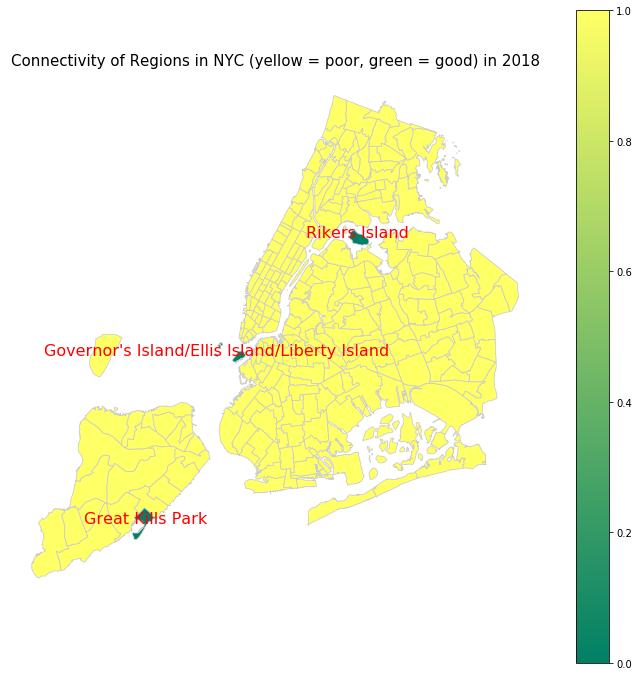

In [197]:
%%time
import matplotlib.pyplot as plt
temp_1 = []
df['coords'] = df['geometry'].apply(lambda x: x.representative_point().coords[:])
df['coords'] = [coords[0] for coords in df['coords']]
fig, ax = plt.subplots(1, figsize=(12, 12))
plt.axis('off')

df.plot(column='poor_connectivity2018', ax=ax, legend=True,cmap='summer', linewidth=0.8, edgecolor='0.8');
for idx, row in df.iterrows():
    if(row['poor_connectivity2018'] == 0):
        if(np.isin(row['zone'],temp_1) == False):
            temp_1.append(row['zone'])
            plt.annotate(s=row['zone'], xy=row['coords'],horizontalalignment='center',fontsize=16,fontweight=6,color='red')
ax.set_title('Connectivity of Regions in NYC (yellow = poor, green = good) in 2018', fontdict={'fontsize': '15', 'fontweight' : '3'})

In [13]:
%%time
import psycopg2
from sqlalchemy import create_engine

conn = psycopg2.connect("host=localhost dbname=movie-data user=postgres password='postgres'")
cur = conn.cursor()
# poor connectivity
cur.execute("select distinct DOLocationID,Store_and_fwd_flag from taxisample where date_part('year', tpep_pickup_datetime)=2019 and store_and_fwd_flag='N'")
result = list(dict.fromkeys(cur))
result.sort()

Wall time: 701 ms


In [14]:
%%time
import numpy as np
poor_connectivity = []
min_df = df['LocationID']

for j in range(len(min_df)):
    if np.isin(min_df[j],result):
        poor_connectivity.append(1)
    else:
        poor_connectivity.append(0)
df['poor_connectivity2019'] = poor_connectivity
df.head()

Wall time: 59.4 ms


,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry,poor_connectivity2018,poor_connectivity2019
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((933100.9183527103 192536.0856972019,...",1,0
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"(POLYGON ((1033269.243591294 172126.0078125, 1...",1,0
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((1026308.769506663 256767.6975403726,...",1,0
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.4667968601 203714.0759887695,...",1,1
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((935843.3104932606 144283.335850656, ...",1,0


Wall time: 203 ms


Text(0.5, 1, 'Regions of NYC with poor connectivity (yellow) in 2019')

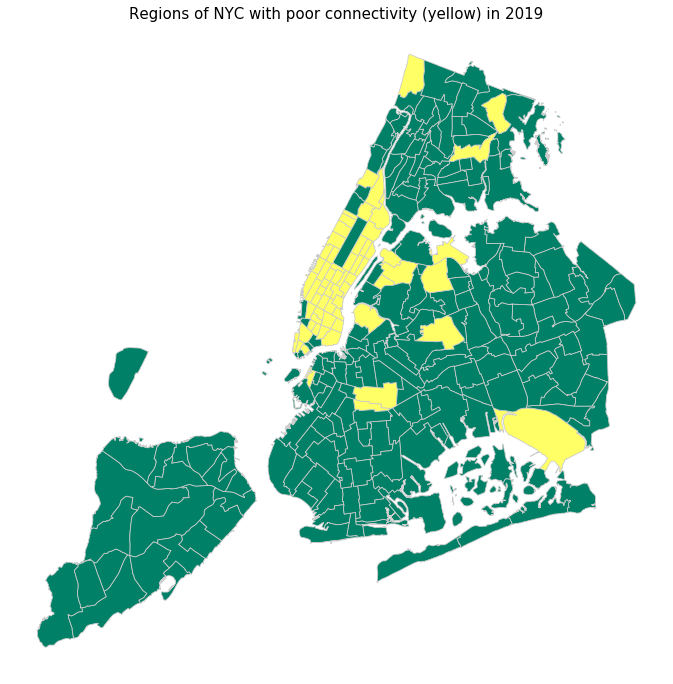

In [172]:
%%time
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, figsize=(12, 12))
plt.axis('off')
df.plot(column='poor_connectivity2019', ax=ax, legend=False,cmap='summer', linewidth=0.8, edgecolor='0.8');
ax.set_title('Regions of NYC with poor connectivity (yellow) in 2019', fontdict={'fontsize': '15', 'fontweight' : '3'})

In [16]:
%%time
import psycopg2
from sqlalchemy import create_engine

conn = psycopg2.connect("host=localhost dbname=movie-data user=postgres password='postgres'")
cur = conn.cursor()
# poor connectivity
cur.execute("select payment_type,count(payment_type) from taxisample where payment_type= 1 OR payment_type=2 group by payment_type")
result = cur.fetchall()
payment = ['Credit Card','Cash']
count = [x[1] for x in result]

Wall time: 721 ms


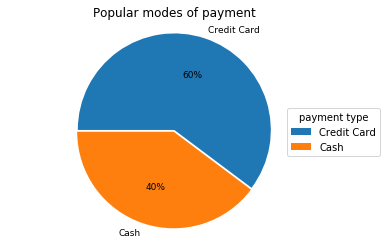

Wall time: 271 ms


In [17]:
%%time
#plt.pie(sizes, labels=labels, autopct='%1.0f%%', pctdistance=1.1, labeldistance=1.2)
explode = (0.01, 0.01)
plt.pie(count,labels=payment,autopct='%1.0f%%',explode=explode,textprops={'fontsize': 9}, counterclock=False,startangle=180)
plt.axis('equal')

plt.legend(payment,title='payment type', bbox_to_anchor=(1,0.5),loc='right', bbox_transform=plt.gcf().transFigure)
plt.title("Popular modes of payment")
plt.show()

In [117]:
%%time
import psycopg2
from sqlalchemy import create_engine

conn = psycopg2.connect("host=localhost dbname=movie-data user=postgres password='postgres'")
cur = conn.cursor()
# sum of trip distance from starting location
cur.execute("select PULocationID,avg(trip_distance) from taxisample group by PULocationID")
result = list(dict.fromkeys(cur))
result.sort()
distances = {}
for j in range(len(result)):
    distances[result[j][0]] = result[j][1]

Wall time: 1.89 s


{1: 1.71404494531453,
 2: 20.7800006866455,
 3: 7.85413795812377,
 4: 2.56961056219469,
 5: 17.1000003814697,
 6: 4.63200000524521,
 7: 2.53280063790435,
 8: 4.25153847382619,
 9: 7.65608691173079,
 10: 12.480766864025,
 11: 7.86937496811152,
 12: 4.27002860844476,
 13: 3.88749628876281,
 14: 6.47643680802022,
 15: 11.1424999435743,
 16: 9.30684195066753,
 17: 3.47707509236933,
 18: 6.08785715344406,
 19: 8.92272739247842,
 20: 6.36999997671913,
 21: 7.54314286453383,
 22: 8.25673914085264,
 23: 16.4600001302632,
 24: 2.3531713549249,
 25: 3.31466514910873,
 26: 5.51551402060785,
 28: 9.50915787118046,
 29: 7.8385714866221,
 31: 5.70999997854233,
 32: 9.20704545690255,
 33: 3.80801249674987,
 34: 2.45136363736608,
 35: 7.1104196381423,
 36: 4.85543308090272,
 37: 4.17804346614234,
 38: 11.5577273368835,
 39: 8.18942674026368,
 40: 3.28486283957271,
 41: 2.32452243477725,
 42: 2.5674577050778,
 43: 2.17748224633774,
 44: 10.8833335240682,
 45: 3.02040663485897,
 46: 22.1949996948242,
 4

In [118]:
%%time
import numpy as np
total_distance = []
min_df = df['LocationID']

for j in range(len(min_df)):
    if min_df[j] in distances:
        total_distance.append(distances[min_df[j]])
    else:
        total_distance.append(0)
df['total_distance'] = total_distance
df.head()

Wall time: 9.98 ms


,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry,poor_connectivity2018,poor_connectivity2019,total_distance,coords
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((933100.9183527103 192536.0856972019,...",1,0,1.714045,"(935223.026585771, 190535.05257488793)"
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"(POLYGON ((1033269.243591294 172126.0078125, 1...",1,0,20.780001,"(1032515.6723034503, 167292.49319458753)"
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((1026308.769506663 256767.6975403726,...",1,0,7.854138,"(1025882.734753933, 254779.60063055903)"
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.4667968601 203714.0759887695,...",1,1,2.569611,"(990618.795051066, 203105.53231811523)"
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((935843.3104932606 144283.335850656, ...",1,0,17.100000,"(931467.962751084, 139837.47838920355)"


Wall time: 281 ms


Text(0.5, 1, 'Zones where long distance trips were booked')

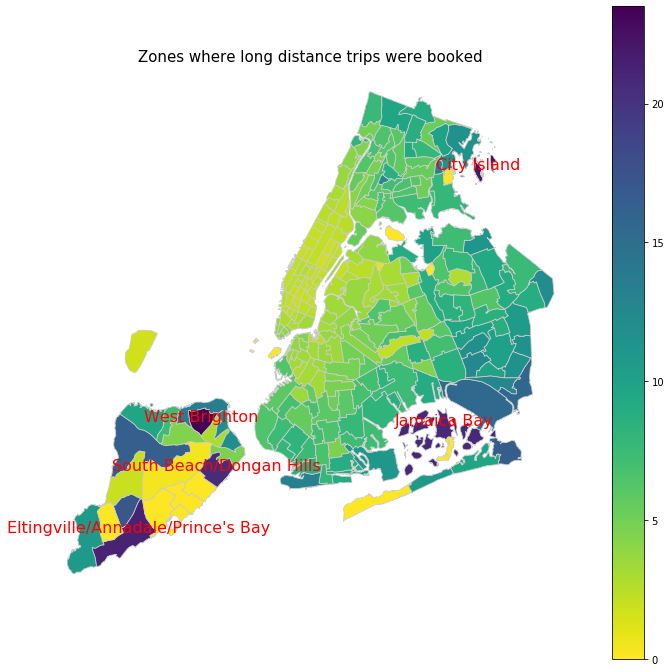

In [198]:
%%time
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, figsize=(12, 12))
plt.axis('off')

df.plot(column='total_distance', ax=ax, legend=True,cmap='viridis_r', linewidth=0.8, edgecolor='0.8');
for idx, row in df.iterrows():
    if(row['total_distance'] > 20):
        plt.annotate(s=row['zone'], xy=row['coords'],horizontalalignment='center',fontsize=16,fontweight=6,color='red')
ax.set_title('Zones where long distance trips were booked', fontdict={'fontsize': '15', 'fontweight' : '3'})

In [134]:
%%time
import psycopg2
from sqlalchemy import create_engine

conn = psycopg2.connect("host=localhost dbname=movie-data user=postgres password='postgres'")
cur = conn.cursor()
# sum of trip distance from starting location
cur.execute("select PULocationID,count(PULocationID) from taxisample group by PULocationID")
result = list(dict.fromkeys(cur))
result.sort()
distances = {}
for j in range(len(result)):
    distances[result[j][0]] = result[j][1]
distances

Wall time: 663 ms


{1: 89,
 2: 1,
 3: 29,
 4: 2234,
 5: 1,
 6: 5,
 7: 1871,
 8: 13,
 9: 23,
 10: 326,
 11: 16,
 12: 699,
 13: 8084,
 14: 87,
 15: 12,
 16: 38,
 17: 253,
 18: 42,
 19: 22,
 20: 17,
 21: 35,
 22: 46,
 23: 11,
 24: 3128,
 25: 881,
 26: 107,
 28: 95,
 29: 35,
 31: 4,
 32: 44,
 33: 800,
 34: 22,
 35: 143,
 36: 127,
 37: 276,
 38: 22,
 39: 157,
 40: 401,
 41: 4502,
 42: 2187,
 43: 17603,
 44: 3,
 45: 2533,
 46: 2,
 47: 48,
 48: 38417,
 49: 304,
 50: 9275,
 51: 103,
 52: 423,
 53: 30,
 54: 22,
 55: 37,
 56: 93,
 57: 2,
 59: 2,
 60: 24,
 61: 354,
 62: 90,
 63: 46,
 64: 8,
 65: 1221,
 66: 483,
 67: 51,
 68: 26393,
 69: 145,
 70: 139,
 71: 80,
 72: 96,
 73: 5,
 74: 4687,
 75: 8081,
 76: 204,
 77: 63,
 78: 44,
 79: 29690,
 80: 411,
 81: 38,
 82: 417,
 83: 142,
 84: 4,
 85: 75,
 86: 24,
 87: 6197,
 88: 3697,
 89: 209,
 90: 17205,
 91: 117,
 92: 72,
 93: 167,
 94: 38,
 95: 194,
 96: 32,
 97: 847,
 98: 14,
 99: 2,
 100: 21616,
 101: 29,
 102: 25,
 106: 116,
 107: 22730,
 108: 21,
 111: 1,
 112: 329,
 1

In [135]:
%%time
import numpy as np
total_distance = []
min_df = df['LocationID']

for j in range(len(min_df)):
    if min_df[j] in distances:
        total_distance.append(distances[min_df[j]])
    else:
        total_distance.append(0)
df['no_of_trips'] = total_distance
df.head()

Wall time: 14 ms


,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry,poor_connectivity2018,poor_connectivity2019,total_distance,coords,no_of_trips
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((933100.9183527103 192536.0856972019,...",1,0,1.714045,"(935223.026585771, 190535.05257488793)",89
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"(POLYGON ((1033269.243591294 172126.0078125, 1...",1,0,20.780001,"(1032515.6723034503, 167292.49319458753)",1
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((1026308.769506663 256767.6975403726,...",1,0,7.854138,"(1025882.734753933, 254779.60063055903)",29
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.4667968601 203714.0759887695,...",1,1,2.569611,"(990618.795051066, 203105.53231811523)",2234
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((935843.3104932606 144283.335850656, ...",1,0,17.100000,"(931467.962751084, 139837.47838920355)",1


Wall time: 236 ms


Text(0.5, 1, 'Locations with highest number of trips')

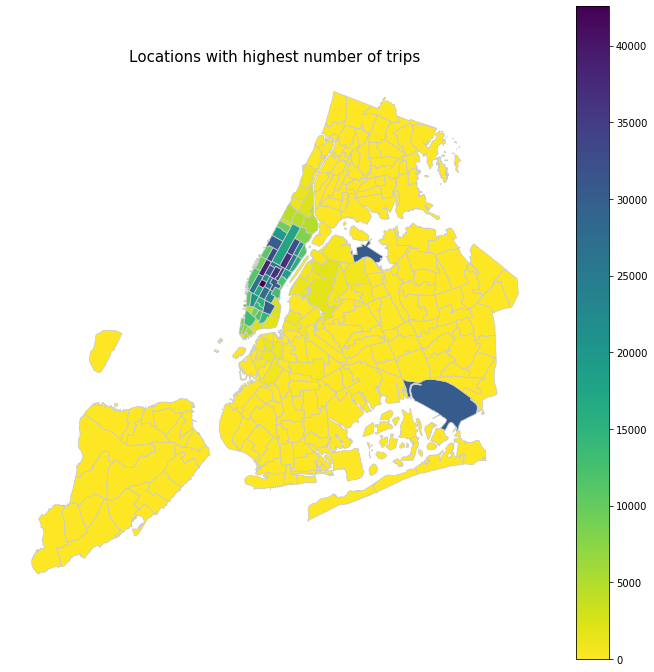

In [202]:
%%time
import matplotlib.pyplot as plt
temp_2 = []

fig, ax = plt.subplots(1, figsize=(12, 12))
plt.axis('off')

df.plot(column='no_of_trips', ax=ax, legend=True,cmap='viridis_r', linewidth=0.8, edgecolor='0.8');
ax.set_title('Locations with highest number of trips', fontdict={'fontsize': '15', 'fontweight' : '3'})